# Example of sam2 vos high quality

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


## Preprocess

NOTE: see the other notebook `04_sam2-vos.ipynb` for preprocessing.

# First-Frame Mask

We create the masks for the first frame. This will be used for the rest of the video. This time, we add some additional quality settings:
- `apply_postprocessing`

In [3]:
import numpy as np
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# define your model config and checkpoint paths
sam2_checkpoint = "./sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

# build the SAM2 model
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=True)

# create the automatic mask generator
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [4]:
# ADT_PROCESSED_DIR = "~/cs-747-project/adt_processed_vos"
SCENE_NAME = "Apartment_release_golden_skeleton_seq100_10s_sample"
base_video_dir = f"/home/ubuntu/cs-747-project/vos-hd/adt_0_input_video"
video_scene_dir = f"{base_video_dir}/{SCENE_NAME}"

# Get the first image from video_scene_dir
first_image_example = os.listdir(video_scene_dir)[0]
print(f"First image path: {first_image_example}")

First image path: 87552137324100.jpg


In [5]:
# Display the first frame image as an example
image_path = f"{video_scene_dir}/{first_image_example}"
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

# generate initial masks for the first frame
masks = mask_generator.generate(image_np)


In [7]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

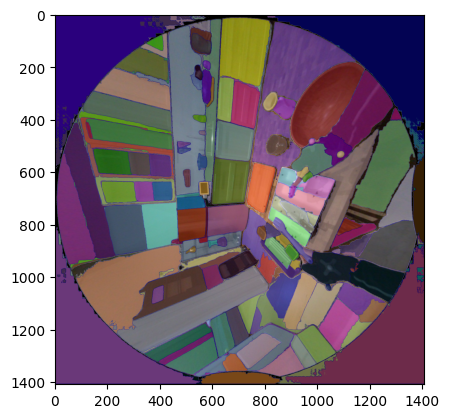

In [8]:
# Display the masks
plt.imshow(image)
show_anns(masks)
plt.show() 

# All objects in one image


In [9]:
# Create a directory to save the first-frame masks
video_name = SCENE_NAME # file structued used by vos script. we can clean this up later
init_masks_dir = f"/home/ubuntu/cs-747-project/vos-hd/adt_1_init_masks"
os.makedirs(os.path.join(init_masks_dir, video_name), exist_ok=True)

In [10]:
from utils.vos_inference import save_masks_to_dir, DAVIS_PALETTE

per_obj_output_mask = {
    idx: mask["segmentation"] for idx, mask in enumerate(masks)
}

# Save the mask to the output directory
save_masks_to_dir(
    init_masks_dir,
    video_name,
    first_image_example,
    per_obj_output_mask,
    height=image_np.shape[0],
    width=image_np.shape[1],
    per_obj_png_file=False, # all in one image
    output_palette=DAVIS_PALETTE,
)

In [11]:
from utils.vos_inference import vos_inference
from sam2.build_sam import build_sam2_video_predictor

# sam2_checkpoint = "./sam2.1_hiera_large.pt"
# model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
# from vos_inference utils
sam2_checkpoint = "./sam2.1_hiera_base_plus.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml" 

# Whether use separate per-object PNG files for input and output masks. This is used by SA-V dataset.
# I think we want this for EgoLifter?
per_obj_png_file = False

# if we use per-object PNG files, they could possibly overlap in inputs and outputs
hydra_overrides_extra = [
    "++model.non_overlap_masks=" + ("false" if per_obj_png_file else "true")
]

predictor = build_sam2_video_predictor(
    config_file=model_cfg,
    ckpt_path=sam2_checkpoint,
    apply_postprocessing=False, # TODO experiment with true
    hydra_overrides_extra=hydra_overrides_extra,
    vos_optimized=True,
)

Image encoder compilation is enabled. First forward pass will be slow.
Compiling all components for VOS setting. First time may be very slow.


In [12]:
base_video_dir = f"/home/ubuntu/cs-747-project/vos-hd/adt_0_input_video"
init_masks_dir = f"/home/ubuntu/cs-747-project/vos-hd/adt_1_init_masks"
output_masks_dir = f"/home/ubuntu/cs-747-project/vos-hd/adt_2_masks"

# Make sure the output directory exists
os.makedirs(os.path.join(output_masks_dir, video_name), exist_ok=True)

In [14]:
video_dir = os.path.join(base_video_dir, video_name)
print(f"loading video frames from {video_dir}")

# Try using the new VOS inference function (TODO later try the interference per object function)
vos_inference(
    predictor=predictor,
    base_video_dir=base_video_dir,
    input_mask_dir=init_masks_dir,
    output_mask_dir=output_masks_dir,
    video_name=video_name,
    # score_thresh=0.0,
    # Just do first frame for now. But we will want to experiment with more frames later
    use_all_masks=False,
    # Here, we try NOT using the per-object PNG files. 
    per_obj_png_file=False,
)

loading video frames from /home/ubuntu/cs-747-project/vos-hd/adt_0_input_video/Apartment_release_golden_skeleton_seq100_10s_sample
loading video frames from /home/ubuntu/cs-747-project/vos-hd/adt_0_input_video/Apartment_release_golden_skeleton_seq100_10s_sample


propagate in video:   0%|          | 1/267 [00:00<00:28,  9.23it/s]/home/ubuntu/egolifter/.venv/lib/python3.10/site-packages/torch/_inductor/lowering.py:1713: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(
propagate in video:  38%|███▊      | 102/267 [03:54<06:20,  2.30s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.01 GiB. GPU 0 has a total capacity of 22.07 GiB of which 1002.25 MiB is free. Including non-PyTorch memory, this process has 21.08 GiB memory in use. Of the allocated memory 19.80 GiB is allocated by PyTorch, with 536.00 MiB allocated in private pools (e.g., CUDA Graphs), and 951.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [24]:
# Save the frames as a video
import cv2
import os
import glob
import imageio
import numpy as np
from tqdm import tqdm

def save_video_from_frames(frame_dir, output_path, fps=30):
    # Get all the image files in the directory
    images = sorted(glob.glob(os.path.join(frame_dir, "*.png")), key=lambda x: int(os.path.basename(x).split(".")[0]))

    # Check if there are any images
    if not images:
        print("No images found in the directory.")
        return
    
    # Read the images and convert them to a format suitable for video
    frames = []
    for img_path in tqdm(images, desc="Reading images"):
        img = Image.open(img_path).convert("RGB")
        frames.append(np.array(img))

    imageio.mimwrite(output_path, frames, fps=fps, codec='libx264', quality=8)
    
    print(f"Video saved to {output_path}")

# Example usage
frame_dir = os.path.join(output_masks_dir, video_name)
output_path = os.path.join(output_masks_dir, f"{video_name}.mp4")
save_video_from_frames(frame_dir, output_path, fps=30)


Reading images: 100%|██████████| 267/267 [00:02<00:00, 109.50it/s]


Video saved to /home/ubuntu/cs-747-project/adt_2_masks/Apartment_release_golden_skeleton_seq100_10s_sample.mp4
